In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
from keras import optimizers

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mean_squared_error
from keras import layers as KL

import uproot
import numpy
import matplotlib.pyplot
import pandas as pd
from pathlib import Path

from keras.layers import Input, Dense, Lambda, Layer, LeakyReLU, ReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, BaseLogger, \
TerminateOnNaN, Callback, ModelCheckpoint, LambdaCallback

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from keras.constraints import max_norm
from sklearn.externals.joblib import dump, load

from numpy.random import seed
import time

import json
import pickle
import os
import shutil

from ray.tune.integration.keras import TuneReporterCallback
import ray
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler, ASHAScheduler, pbt, PopulationBasedTraining

import random as rn
np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

# import ray
# from ray.tune.integration.keras import TuneReporterCallback
# from ray import tune
# from ray.tune.schedulers import AsyncHyperBandScheduler, ASHAScheduler, PopulationBasedTraining
import random
import csv

from config import *
from vae_utility import *

Using TensorFlow backend.
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/h

In [2]:
mm = MinMaxScaler()

In [3]:
cols_ordered = ['mt', 'met', 'mct', 'delta_phi','lep1Pt', 'mjj',
            'fatjet1Pt', 'nJet30', 'nBJet30_DL1', 'nFatjets', 'type', 'weight' ]

In [4]:
def KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior):
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return 0.5 * K.sum(kl_loss, axis=-1)

#######################################################################
def RecoProb_forVAE(x, par1, par2, par3, w):

    N = 0
    nll_loss = 0

    if Nf_lognorm != 0:

        for i in range(Nf_lognorm):

            #Log-Normal distributed variables
            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            fraction = par3[:,i:i+1]
            x_clipped = K.clip(x[:,i:i+1], clip_x_to0, 1e8)
            single_NLL = K.tf.where(K.less(x[:,i:i+1], clip_x_to0),
                                    -K.log(fraction),
                                        -K.log(1-fraction)
                                        + K.log(sigma)
                                        + K.log(x_clipped)
                                        + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

        N += Nf_lognorm

    if Nf_PDgauss != 0:

        for i in range(N, N+Nf_PDgauss):

            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            norm_xp = K.tf.divide(x[:,i:i+1] + 0.5 - mu, sigma)
            norm_xm = K.tf.divide(x[:,i:i+1] - 0.5 - mu, sigma)
            sqrt2 = 1.4142135624
            single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

            norm_0 = K.tf.divide(-0.5 - mu, sigma)
            aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
            single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

    return nll_loss


def IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,:1]
    sigma = par2[:,:1]
    fraction = par3[:,:1]
    x_clipped = K.clip(x[:,:1], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:1], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,1:2]
    sigma = par2[:,1:2]
    fraction = par3[:,1:2]
    x_clipped = K.clip(x[:,1:2], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,1:2], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,2:3]
    sigma = par2[:,2:3]
    fraction = par3[:,2:3]
    x_clipped = K.clip(x[:,2:3], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,2:3], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_4(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,3:4]
    sigma = par2[:,3:4]
    fraction = par3[:,3:4]
    x_clipped = K.clip(x[:,3:4], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,3:4], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_5(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,4:5]
    sigma = par2[:,4:5]
    fraction = par3[:,4:5]
    x_clipped = K.clip(x[:,4:5], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,4:5], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_6(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,5:6]
    sigma = par2[:,5:6]
    fraction = par3[:,5:6]
    x_clipped = K.clip(x[:,5:6], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,5:6], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss


def individualRecoProb_forVAE_discrete_4(x, par1, par2, w):
    nll_loss = 0

    mu = par1[:,3:4]
    sigma = par2[:,3:4]
    norm_xp = K.tf.divide(x[:,3:4] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,3:4] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss



def individualRecoProb_forVAE_discrete_6(x, par1, par2, w):
    nll_loss = 0

    mu = par1[:,5:6]
    sigma = par2[:,5:6]
    norm_xp = K.tf.divide(x[:,5:6] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,5:6] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss


def individualRecoProb_forVAE_discrete_7(x, par1, par2, w):
    nll_loss = 0

    mu = par1[:,6:7]
    sigma = par2[:,6:7]
    norm_xp = K.tf.divide(x[:,6:7] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,6:7] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss



def individualRecoProb_forVAE_discrete_8(x, par1, par2, w):
    nll_loss = 0

    mu = par1[:,7:8]
    sigma = par2[:,7:8]
    norm_xp = K.tf.divide(x[:,7:8] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,7:8] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

# def IndividualRecoProb_forVAE_lognorm_6(x, par1, par2, par3, w):
#     N = 0
#     nll_loss = 0

#     mu = par1[:,5:6]
#     sigma = par2[:,5:6]
#     fraction = par3[:,5:6]
#     x_clipped = K.clip(x[:,5:6], clip_x_to0, 1e8)
#     single_NLL = K.tf.where(K.less(x[:,5:6], clip_x_to0),
#                             -K.log(fraction),
#                                 -K.log(1-fraction)
#                                 + K.log(sigma)
#                                 + K.log(x_clipped)
#                                 + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
#     nll_loss += K.sum(w*single_NLL, axis=-1)

#     return nll_loss



# def individualRecoProb_forVAE_discrete_7(x, par1, par2, w):
#     N = Nf_lognorm
#     nll_loss = 0

#     mu = par1[:,6:7]
#     sigma = par2[:,6:7]
#     norm_xp = K.tf.divide(x[:,6:7] + 0.5 - mu, sigma)
#     norm_xm = K.tf.divide(x[:,6:7] - 0.5 - mu, sigma)
#     sqrt2 = 1.4142135624
#     single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

#     norm_0 = K.tf.divide(-0.5 - mu, sigma)
#     aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
#     single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

#     nll_loss += K.sum(w*single_NLL, axis=-1)

#     return nll_loss

# def individualRecoProb_forVAE_discrete_8(x, par1, par2, w):
#     N = Nf_lognorm
#     nll_loss = 0

#     mu = par1[:,7:8]
#     sigma = par2[:,7:8]
#     norm_xp = K.tf.divide(x[:,7:8] + 0.5 - mu, sigma)
#     norm_xm = K.tf.divide(x[:,7:8] - 0.5 - mu, sigma)
#     sqrt2 = 1.4142135624
#     single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

#     norm_0 = K.tf.divide(-0.5 - mu, sigma)
#     aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
#     single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

#     nll_loss += K.sum(w*single_NLL, axis=-1)

#     return nll_loss

In [5]:
class CustomKLLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomKLLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        mu, sigma, mu_prior, sigma_prior = inputs
        return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior)


class CustomRecoProbLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomRecoProbLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return RecoProb_forVAE(x, par1, par2, par3, w = w)

#################################################################################################à
class CustomIndividualLogNorLayer_1(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_1, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w = ind_w[0])

class CustomIndividualLogNorLayer_2(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_2, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w = ind_w[1])


class CustomIndividualLogNorLayer_3(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_3, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w = ind_w[2])

class CustomIndividualLogNorLayer_4(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_4, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_4(x, par1, par2, par3, w = ind_w[3])

class CustomIndividualLogNorLayer_5(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_5, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_5(x, par1, par2, par3, w = ind_w[4])
    
class CustomIndividualLogNorLayer_6(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_6, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_6(x, par1, par2, par3, w = ind_w[5])

#         class CustomIndividualLogNorLayer_6(Layer):
#             def __init__(self, **kwargs):
#                 self.is_placeholder = True
#                 super(CustomIndividualLogNorLayer_6, self).__init__(**kwargs)

#             def call(self, inputs):
#                 x, par1, par2, par3 = inputs
#                 return IndividualRecoProb_forVAE_lognorm_6(x, par1, par2, par3, w = ind_w[5])

class CustomIndividualTruGauLayer_4(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualTruGauLayer_4, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2 = inputs
        return individualRecoProb_forVAE_discrete_4(x, par1, par2, w = ind_w[3])

class CustomIndividualTruGauLayer_6(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualTruGauLayer_6, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2 = inputs
        return individualRecoProb_forVAE_discrete_6(x, par1, par2, w = ind_w[5])

class CustomIndividualTruGauLayer_7(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualTruGauLayer_7, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2 = inputs
        return individualRecoProb_forVAE_discrete_7(x, par1, par2, w = ind_w[6])
    
class CustomIndividualTruGauLayer_8(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualTruGauLayer_8, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2 = inputs
        return individualRecoProb_forVAE_discrete_8(x, par1, par2, w = ind_w[7])

In [6]:
folds = os.listdir(ray_model_results)
folds

['merged',
 'ray_results_ww_atlas',
 'scan_weights_wz_hpc',
 'ww_3_feats',
 'ww_4_feats',
 'wz_scan_all_hpc']

In [7]:
num = -2
df = pd.read_csv(ray_model_results +folds[num] + '/tune_result_restored.csv')
print(ray_model_results + folds[num])

model_results/ray_results/ww_4_feats


In [8]:

# PATIENCE is not on hpc
try:
    df = df[['mean_accuracy','keras_info/loss', 'keras_info/KL_loss',
           'keras_info/RecoNLL_loss','config/act_fun', 'config/batch_size','config/intermediate_dim', 
                                'config/kernel_max_norm','config/latent_dim', 
                                'config/lr',
                                'config/patience',
    #                             
                                'config/weight_KL_loss','num_train']]
except:
    
    df = df[['mean_accuracy','keras_info/loss', 'keras_info/KL_loss',
           'keras_info/RecoNLL_loss','config/act_fun', 'config/batch_size','config/intermediate_dim', 
                                'config/kernel_max_norm','config/latent_dim', 
                                'config/lr',
#                                 'config/patience',
    #                             
                                'config/weight_KL_loss','num_train']]


In [9]:
df.sort_values('mean_accuracy').head(10)

,mean_accuracy,keras_info/loss,keras_info/KL_loss,keras_info/RecoNLL_loss,config/act_fun,config/batch_size,config/intermediate_dim,config/kernel_max_norm,config/latent_dim,config/lr,config/weight_KL_loss,num_train
5,-58.343512,-51.663391,8.551233,-58.504378,elu,100,50,100,3,0.003,0.8,train_vae_14
28,-57.835318,-54.078603,9.293218,-57.795890,elu,100,30,2000,3,0.003,0.4,train_vae_21
13,-43.100955,-39.501241,8.801795,-43.021959,relu,200,20,100,3,0.003,0.4,train_vae_29
2,-38.021682,-35.268782,8.487793,-37.815121,relu,100,50,100,3,0.001,0.3,train_vae_11
12,-36.939460,-31.605866,8.336639,-36.607850,relu,100,20,100,3,0.001,0.6,train_vae_28
8,-35.235917,-32.611555,8.714113,-36.097200,relu,1000,150,500,3,0.001,0.4,train_vae_24
3,-23.970456,-18.661203,7.550129,-24.701306,relu,500,120,100,3,0.001,0.8,train_vae_12
0,-23.675731,-20.106600,8.422373,-23.475549,elu,800,20,100,3,0.003,0.4,train_vae_0
6,-13.365561,-11.167806,5.491463,-13.364391,relu,200,150,500,2,0.003,0.4,train_vae_15
29,-13.252391,-10.837860,6.239856,-13.333802,elu,200,20,2000,2,0.006,0.4,train_vae_22


In [10]:
df_sorted = df.sort_values('mean_accuracy')

In [13]:
ranking = 10
num_train_list = []
src = ray_model_results + folds[num] + '/'
dst = 'model_results/best_from_ray/{}/'.format(folds[num])

try:
    shutil.rmtree(dst)
    os.makedirs(dst)
except:
    os.makedirs(dst)
#take the first n train_vae_name from dataset:
for i in range(ranking):
    num_train_list.append(df_sorted.iloc[i,]['num_train'])
    
for trains in os.listdir(ray_model_results + folds[num]):
    train = trains.split('act_fun')[0].strip('_')
    if train in num_train_list:
        print(train,num_train_list.index(train))
        shutil.copy(src + trains + '/ray_tuned_vae.h5', dst + 'vae_{}.h5'\
                    .format(num_train_list.index(train)))
        shutil.copy(src + trains + '/ray_tuned_autoencoder.h5', dst + 'autoencoder_{}.h5'\
                    .format(num_train_list.index(train)))

train_vae_0 7
train_vae_11 3
train_vae_12 6
train_vae_14 0
train_vae_15 8
train_vae_24 5
train_vae_28 4
train_vae_29 2
train_vae_21 1
train_vae_22 9


In [115]:
original_dim = 3
Nf_lognorm = 3

In [116]:
# WW from atlas >>> rank_1 the best

rank = 9
latent_dim = df_sorted.iloc[rank,]['config/latent_dim']
intermediate_dim = df_sorted.iloc[rank,]['config/intermediate_dim']
act_fun = df_sorted.iloc[rank,]['config/act_fun']
weight_KL_loss = df_sorted.iloc[rank,]['config/weight_KL_loss']

In [117]:
from keras.models import load_model
custom_objects = {
    'original_dim': original_dim,
    'latent_dim': latent_dim,
    'intermediate_dim': intermediate_dim,
    'act_fun': act_fun,
    'Nf_lognorm' : Nf_lognorm,
    'CustomKLLossLayer' : CustomKLLossLayer,
    'CustomRecoProbLayer' : CustomRecoProbLayer,
    
    'CustomIndividualLogNorLayer_1' : CustomIndividualLogNorLayer_1,
    'CustomIndividualLogNorLayer_2' : CustomIndividualLogNorLayer_2,
    'CustomIndividualLogNorLayer_3' : CustomIndividualLogNorLayer_3,
    'CustomIndividualLogNorLayer_4' : CustomIndividualLogNorLayer_4,
    'CustomIndividualLogNorLayer_5' : CustomIndividualLogNorLayer_5,
    'CustomIndividualLogNorLayer_6' : CustomIndividualLogNorLayer_6,
    
    'CustomIndividualTruGauLayer_4' : CustomIndividualTruGauLayer_4,    
    'CustomIndividualTruGauLayer_6' : CustomIndividualTruGauLayer_6,
    'CustomIndividualTruGauLayer_7' : CustomIndividualTruGauLayer_7,
    'CustomIndividualTruGauLayer_8' : CustomIndividualTruGauLayer_8,

#     'metric' :metric,
    'IdentityLoss' : IdentityLoss
}

In [118]:
    components_dict = {

        'mt':5,
        'met':10,
#          'mct':1,
        'delta_phi':10,
#          'lep1Pt':1,
#         'mjj':1,
#          ,'fatjet1Pt', 
#         'nJet30':1, 
#         'nBJet30_DL1':1,                            
#            'nFatjets' 
        }

In [119]:
path = dst + 'vae_{}.h5'.format(rank)

check_vae = path.split('/')[-1]

if 'vae' in check_vae:
    print('you are loading a vae model {}'.format(check_vae))
elif 'autoencoder' in check_vae:
    print(' \x1b[31m pay attention, you are loading autoencoder e not vae \x1b[0m')

# with open('/'.join(path.split('/')[:-1]) + '/' + 'comps_dict.pickle', 'rb') as handle:
#     components_dict = pickle.load(handle)
    
weights = []
for k,v in components_dict.items():
    weights.append(v)

if 0 in weights:
    ind_w = [x if x != 0 else 1 for x in weights]
else:
    ind_w = weights
    
# ind_w are used for uputput from 2 to 10 (for the 8 individual features)
# w are used fot the KL loss and total recon_loss
    
w = weights
print(components_dict)
# print('latent dim', latent_dim)

you are loading a vae model vae_9.h5
{'mt': 5, 'met': 10, 'delta_phi': 10}


In [120]:
cols_sel = list(components_dict.keys())
cols_sel

['mt', 'met', 'delta_phi']

In [121]:
type_mod = 'WW'
type_an = 'merged'
    
print('_'.join([type_mod, type_an]))

WW_merged


In [122]:
infer_component = True #This is automatic inference when all weights in components dicts are == 0
if not np.all(w): #if thera are 0's in the weights, infer components from dictionaries
    print('some zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components
    
    if infer_component == True:
        selected_idx = [cols_sel.index(component) + 2  for component in selected_components]
        print('automatic loss component inference {}'.format(selected_components))
    elif not infer_component:
        selected_components =['mt', 'met', 'mct', 'delta_phi']
        selected_idx = [cols_sel.index(component) + 2 for component in selected_components]
        print('no automatic inference, custom component loss definition {}'.format(selected_components)) 
    
else: #if w are all != 0 we need to input our selection
    
    print('no zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components
    
    if infer_component == True:
        selected_idx = [cols_sel.index(component) + 2  for component in selected_components]
        print('automatic loss component inference {}'.format(selected_components))
    else:    
        selected_components = ['mt', 'met'
#             ,'mct
            ,'delta_phi'
            ,'lep1Pt'
                              ]
        print('no zeros in the weights, custom loss component definitions {}'.format(selected_components)) 
        selected_idx = [cols_sel.index(component) + 2 for component in selected_components]
        
original_dim = len(components_dict.keys())


Nf_lognorm=0
Nf_PDgauss=0
for selected in selected_components:
    if selected in cols[:-5]:
        Nf_lognorm += 1
    else:
        Nf_PDgauss += 1
    
print('or dim {}: lognorm {} and pdgauss {}'.format(original_dim, Nf_lognorm, Nf_PDgauss))

no zeros in the weights
automatic loss component inference ['mt', 'met', 'delta_phi']
or dim 3: lognorm 3 and pdgauss 0


In [123]:
vae = load_model(path, custom_objects=custom_objects)
print ('Loaded')
print("\x1b[31m model: {} trained on non-zero loss: {} \x1b[0m \n".format(path.split('/')[-1], training_components))
print("\x1b[31m total loss weights {} and individual loss weight: {} \x1b[0m \n".format(w,ind_w))
# print("\x1b[31m selected component for bump loss {} that is: {} \x1b[0m \n".format(w,ind_w))
print('selected output indexes {} (shifetd by two beacuse of model output) for the component sum that is: {}'\
      .format(selected_idx, selected_components))

Loaded
 model: vae_9.h5 trained on non-zero loss: ['mt', 'met', 'delta_phi']  

 total loss weights [5, 10, 10] and individual loss weight: [5, 10, 10]  

selected output indexes [2, 3, 4] (shifetd by two beacuse of model output) for the component sum that is: ['mt', 'met', 'delta_phi']


In [124]:
# if path.split('/')[1] != 'model_dependent':
    
model_dependent = False

train_val_test = train_val_test_wz + '/' + type_mod + '/bkg_' + type_an + '/'

back = np.load(train_val_test + 'background.npy', allow_pickle=True)
train = np.load(train_val_test + 'background_train.npy',allow_pickle=True)
val = np.load(train_val_test + 'background_val.npy',allow_pickle=True)

try:
    test = np.load(train_val_test + 'background_test.npy',allow_pickle=True)
    split_test = 1/(np.sum(test[:,-1])/(np.sum(back[:,-1])))
except:
    print('no test, tacking val')
    val = np.load(train_val_test + 'background_val.npy',allow_pickle=True)
    sample = 'background_val.npy'

split_train = 1/(np.sum(train[:,-1])/(np.sum(back[:,-1])))
split_val = 1/(np.sum(val[:,-1])/(np.sum(back[:,-1])))
print('model independent test, val reweighting {}, {}'.format(split_test, split_val))
print(train_val_test )

model independent test, val reweighting 2.537169984920201, 3.282933446730153
numpy_data//WW/bkg_merged/


In [125]:
# type_mod_sig = 'WW'
# type_an_sig = 'boosted_2_9'
type_mod_sig = type_mod
type_an_sig = type_an

In [127]:
min_max = False

In [128]:
start_c = 0
end_c = None
range_mjj = []
if 'mjj' in path:
    print('mjj in path')
    range_mjj.append(int(path.split('/')[-3].split('mjj')[-1].strip('_').split('_')[0]))
    range_mjj.append(int(path.split('/')[-3].split('mjj')[-1].strip('_').split('_')[1]))
else:
    range_mjj = [-10**9,10**9]

train_df = pd.DataFrame(train, columns=cols)

if ('mjj' in cols_sel) | ('mjj' in path):
    print(len(train_df))
    train_df = train_df[((train_df['mjj']>=range_mjj[0])&(train_df['mjj']<range_mjj[1]))]
    print('mjj cuts {} {}'.format(range_mjj[0], range_mjj[1]))
    print(len(train_df))
else:
    print('no mjj cuts')

sample_tr = train_df[cols_sel[start_c:end_c]].values
if min_max:
    sample_tr = mm.fit_transform(sample_tr)

no mjj cuts


In [129]:
all_signal = []
signal_name = []
all_signal_dict = {}

sig_list = []
out_sig_list = []
losses_sig = []

start_c = 0
end_c = None

# range_mjj = []
# if 'mjj' in path:
#     range_mjj.append(int(path.split('/')[-3].split('mjj')[-1].strip('_').split('_')[0]))
#     range_mjj.append(int(path.split('/')[-3].split('mjj')[-1].strip('_').split('_')[1]))
# else:
#     range_mjj = [-10**9,10**9]

numpy_sig = 'numpy_data/{}/sig_{}/'.format(type_mod_sig, type_an_sig)
# numpy_sig = 'numpy_data/{}/sig_{}/'.format('WW', 'boosted_2_9')

signal_name_path = os.listdir(numpy_sig)

for i, name in enumerate(signal_name_path):
    
    sig = np.load(numpy_sig + name,allow_pickle=True)
    sig_df = pd.DataFrame(sig, columns=cols)
    if ('mjj' in cols_sel) | ('mjj' in path):
#         print('mjj cuts')
        sig_df = sig_df[((sig_df['mjj']>=range_mjj[0])&(sig_df['mjj']<range_mjj[1]))]

#     sig_df = sig_df[((sig_df['mct2']>=range_mct2[0])&(sig_df['mct2']<range_mct2[1]))]
    
#     sig_df = sig_df[((sig_df['mt']>=0)&(sig_df['mt']<1000))]
#     sig_df = sig_df[((sig_df['met']>=0)&(sig_df['met']<1000))]
#     sig_df = sig_df[((sig_df['mlb1']>=0)&(sig_df['mlb1']<1000))]
#     sig_df = sig_df[((sig_df['lep1Pt']>=0)&(sig_df['lep1Pt']<1000))]
    if min_max:
        print('normalizing')
        sig_cut = mm.transform(sig_df[cols_sel[start_c:end_c]].values)
        sig_cut = np.concatenate((sig_cut,np.reshape(np.array(sig_df['weight']),(len(sig_df),1))), axis = 1)
    else:
        sig_cut = sig_df[cols_sel[start_c:end_c] + ['weight']].values
    
    sig_list.append(sig_cut)
    
    out_sig_list.append(vae.predict(sig_cut[:,:-1], batch_size=2000))
    losses_sig.append(np.column_stack((weight_KL_loss*out_sig_list[-1][0]+out_sig_list[-1][1],
                            out_sig_list[-1][1], out_sig_list[-1][0])).T)
    
    
    all_signal.append(sig_cut)
    signal_name.append('_'.join(name.split('{}_'.format(type_mod_sig))[1].rstrip('.npy').split('_')[0:2]))
        
    all_signal_dict[signal_name[-1]]=sig_cut
    
print(numpy_sig)

numpy_data/WW/sig_merged/


In [130]:
# sample_name = 'test'
start_c = 0
end_c = None

# if sample_name == 'val':
    
val_factor = split_val
val_df = pd.DataFrame(val, columns=cols)

if ('mjj' in cols_sel) | ('mjj' in path):
    print(len(val_df))
    val_df = val_df[((val_df['mjj']>=range_mjj[0])&(val_df['mjj']<range_mjj[1]))]
    print('mjj cuts {} {}'.format(range_mjj[0], range_mjj[1]))
    print(len(val_df))
else:
    print('no mjj cuts')
    
if min_max:
    sample_v = mm.transform(val_df[cols_sel[start_c:end_c]].values)
    sample_v = np.concatenate((sample_v,np.reshape(np.array(val_df['weight']),(len(val_df),1))), axis = 1)
else:
    sample_v = val_df[cols_sel[start_c:end_c] + ['weight']].values


out_bkg_v = vae.predict(sample_v[:,:-1], batch_size=2000)
loss_bkg_v = np.column_stack((weight_KL_loss*out_bkg_v[0]+out_bkg_v[1], 
                                  out_bkg_v[1], out_bkg_v[0])).T


test_factor = split_test
test_df = pd.DataFrame(test, columns=cols)

if ('mjj' in cols_sel) | ('mjj' in path):
    print(len(test_df))
    test_df = test_df[((test_df['mjj']>=range_mjj[0])&(test_df['mjj']<range_mjj[1]))]
    print('mjj cuts {} {}'.format(range_mjj[0], range_mjj[1]))
    print(len(test_df))
else:
    print('no mjj cuts')

if min_max:
    sample_t = mm.transform(test_df[cols_sel[start_c:end_c]].values)
    sample_t = np.concatenate((sample_t,np.reshape(np.array(test_df['weight']),(len(test_df),1))), axis = 1)
else:
    sample_t = test_df[cols_sel[start_c:end_c] + ['weight']].values

out_bkg_t = vae.predict(sample_t[:,:-1], batch_size=2000)
loss_bkg_t = np.column_stack((weight_KL_loss*out_bkg_t[0]+out_bkg_t[1], 
                                  out_bkg_t[1], out_bkg_t[0])).T
if model_dependent:

    val_factor = split_val
    val_df_b = pd.DataFrame(val_bkg_only, columns=cols)
#         val_df_b = val_df_b[((val_df_b['mbb']>=range_mbb[0])&(val_df_b['mbb']<range_mbb[1]))]
#         val_df_b = val_df_b[((val_df_b['mct2']>=range_mct2[0])&(val_df_b['mct2']<range_mct2[1]))]

#         val_df_b = val_df_b[((val_df_b['mt']>=0)&(val_df_b['mt']<1000))]
#         val_df_b = val_df_b[((val_df_b['met']>=0)&(val_df_b['met']<1000))]
#         val_df_b = val_df_b[((val_df_b['mlb1']>=0)&(val_df_b['mlb1']<1000))]
#         val_df_b = val_df_b[((val_df_b['lep1Pt']>=0)&(val_df_b['lep1Pt']<1000))]
    sample_b = val_df_b[cols_sel[start_c:end_c] + ['weight']].values

    out_bkg_only = vae.predict(sample_b[:,:-1], batch_size=2000)
    loss_bkg_only = np.column_stack((weight_KL_loss*out_bkg_only[0]+out_bkg_only[1], 
                                  out_bkg_only[1], out_bkg_only[0])).T
        
    
sig_factor = 1
print('sig factor: {}'.format(sig_factor))
# print(sample_name, val_factor)   

no mjj cuts
no mjj cuts
sig factor: 1


In [131]:
for i, sel in enumerate(selected_idx):
    print(sel)
    if i == 0:
        all_components_bkg = out_bkg_t[sel]
        all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
    else:
        all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg_t[sel]
                                        , (len(out_bkg_t[sel]),1))), axis = 1)

bump_bkg_loss_t=np.sum(all_components_bkg, axis=1)

test_df['loss'] = bump_bkg_loss_t
        
    
for i, sel in enumerate(selected_idx):
    print(sel)
    if i == 0:
        all_components_bkg = out_bkg_v[sel]
        all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
    else:
        all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg_v[sel]
                                        , (len(out_bkg_v[sel]),1))), axis = 1)

bump_bkg_loss_v=np.sum(all_components_bkg, axis=1)


2
3
4
2
3
4


In [132]:
# signal_name_sel = ['300_150','300_75','500_0','600_150','750_100','700_350',
#               '1000_50', '187_12', '400_200', '800_50']

all_components_sig_list = []
for out_sig in out_sig_list:
    for i, sel in enumerate(selected_idx):
#         print(i,sel)
        if i == 0:
            all_components_sig_temp = out_sig[sel]
            all_components_sig_temp = np.reshape(all_components_sig_temp
                                                 , (len(all_components_sig_temp),1))
        else:
            all_components_sig_temp = (np.concatenate((all_components_sig_temp
                                        , np.reshape(out_sig[sel]
                                            , (len(out_sig[sel]),1))), axis = 1))
            
    all_components_sig_list.append(all_components_sig_temp)
    
bump_sig_loss_list = []

for ix, loss in enumerate(all_components_sig_list):
    
    bump_sig_loss_list.append(np.sum(loss, axis = 1))    
    
# if model_dependent:
#     sig_df = pd.DataFrame(all_signal_dict[sig_inj],columns = cols)
    
#     train_df = pd.DataFrame(train,columns = cols)    
    
#     val_df = pd.DataFrame(val,columns = cols)
#     val_df['loss'] = bump_bkg_loss

#     test_df = pd.DataFrame(test,columns = cols)    

#     val_bkg_only_df = pd.DataFrame(val_bkg_only,columns = cols) 

In [133]:
display_comparison = False
sig_to_plot = True

# centered_sig = sig_inj
# centered_sig = '1000_50'

# if (model_dependent) & (display_comparison):
#     start = signal_name.index(centered_sig)-5
#     end = start+10
# elif sig_to_plot:
#     start = 0
#     end = None
signal_to_plot = ['300_0','400_150','500_100','700_0']
# else:
#     start = 0
#     end = 20

model_results/best_from_ray/merged/vae_9.h5


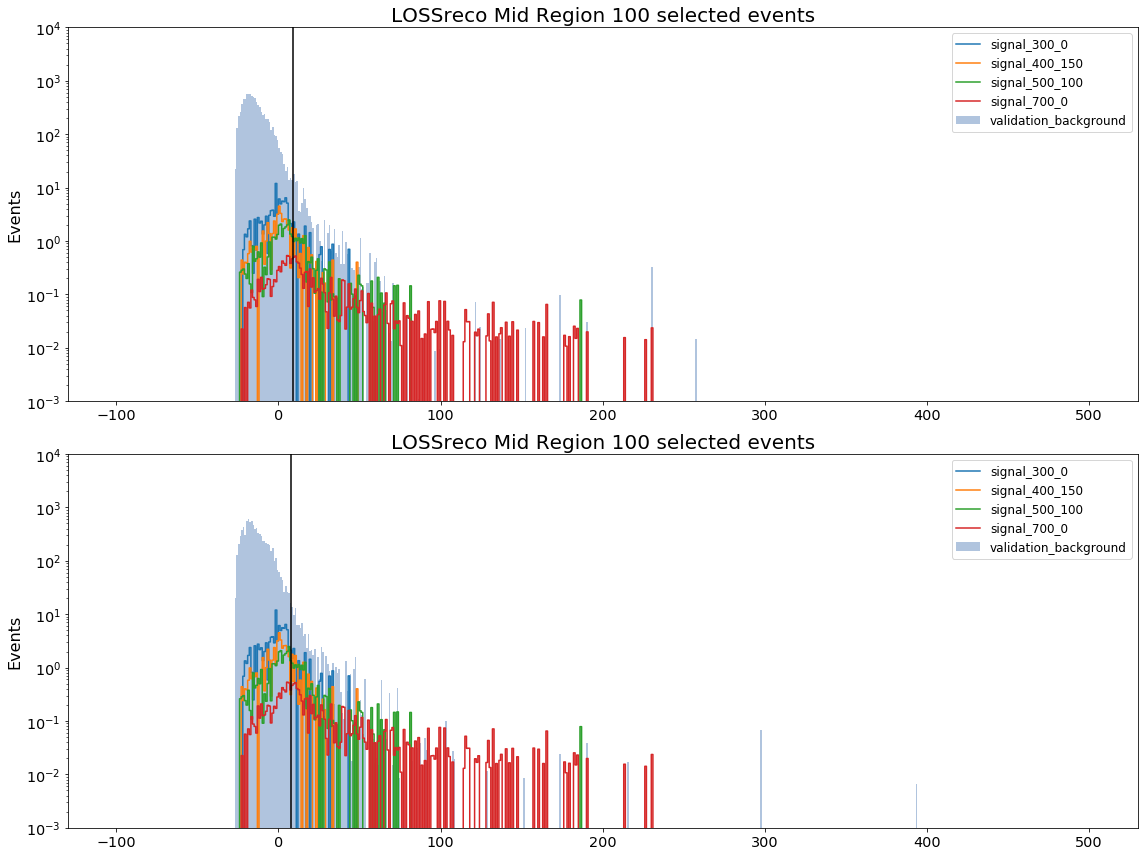

In [134]:
# signal_name_to_plot = ['300_150','500_0','600_150','700_350']
start = 0
end = None
bin_factor=1
histo_start = -100
histo_end=500
f,a = plt.subplots(2,1, figsize=(16, 12))
    
# color=['purple', 'navy', 'red', 'green', 'black', 'blue']
num_loss = 1
n = 100
density = False

for i,bump_sig_loss in enumerate(bump_sig_loss_list[start:end]):
    i = i + start
    if sig_to_plot:
        if signal_name[i] not in signal_to_plot:
            continue
    histo_range = (histo_start, histo_end)
    bins = int((histo_range[1]-histo_range[0])*bin_factor)
    counts_s, edges_s = np.histogram((bump_sig_loss).astype(float),range=histo_range, bins =bins,
                                    weights=sig_list[i][:,-1]*sig_factor,
                                     density=density
                                    )
    a[0].step(x=edges_s, y=np.append(counts_s, 0),
            where="post", label='signal_{}'.format(signal_name[i]))
    a[1].step(x=edges_s, y=np.append(counts_s, 0),
            where="post", label='signal_{}'.format(signal_name[i]))

histo_range = (histo_start, histo_end)
bins = int((histo_range[1]-histo_range[0])*bin_factor)

counts_dval, edges_dval = np.histogram((np.array(bump_bkg_loss_v)).astype(float)
                                       ,range=histo_range,
                                       bins =bins*100,
                                            weights=split_val*sample_v[:,-1],
                                           density=density) 
                                      
th_v = (edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)-1]+
            edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)])/2

a[0].hist((np.array(bump_bkg_loss_v)).astype(float),range=histo_range, bins =bins,
            weights=[split_val]*sample_v[:,-1], 
       stacked=True, 
            density=density,
            color = ['lightsteelblue'], label=['validation_background'])





counts_dval, edges_dval = np.histogram((np.array(bump_bkg_loss_t)).astype(float)
                                       ,range=histo_range,
                                       bins =bins*100,
                                            weights=split_test*sample_t[:,-1],
                                           density=density) 
                                      
th_t = (edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)-1]+
            edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)])/2

a[1].hist((np.array(bump_bkg_loss_t)).astype(float),range=histo_range, bins =bins,
            weights=[split_test]*sample_t[:,-1], 
       stacked=True, 
            density=density,
            color = ['lightsteelblue'], label=['validation_background'])

# if model_dependent:

#     counts_dval, edges_dval = np.histogram((np.array(bump_bkg_only_loss)).astype(float)
#                                            ,range=histo_range,
#                                            bins =bins,
#                                     weights=split_val_bkg_only*val_bkg_only[:,-1],
#                                                density=density) 
    
#     a.step(x=edges_dval, y=np.append(counts_dval, 0),
#             where="post", label='val only backround', color = 'black')
    
a[0].set_ylabel('Events', fontsize=16)
a[0].set_title('LOSSreco Mid Region {} selected events'.format(n), fontsize = 20)

a[0].set_ylim(10**-3,10**4)
a[0].tick_params(labelsize='x-large')
# a.set_xlim(-5,45)
a[0].legend(fontsize = 12)
a[0].set_yscale('log') 
a[0].axvline(int(th_v), color='black')
# lst = [0,5,10,15,th,20,25,30, 35, 40, 45, 50, 60, 70, 80 ,90 ,100, 200, 500, 1000]
# lst = [int(x) for x in lst]
# a.set_xticks(lst)
a[1].set_ylabel('Events', fontsize=16)
a[1].set_title('LOSSreco Mid Region {} selected events'.format(n), fontsize = 20)

a[1].set_ylim(10**-3,10**4)
a[1].tick_params(labelsize='x-large')
# a.set_xlim(-5,45)
a[1].legend(fontsize = 12)
a[1].set_yscale('log') 
a[1].axvline(int(th_t), color='black')
print(path)

plt.tight_layout()

In [135]:
# N EXP on VAL and SIG same curve 
# N = [1,2,5,8,10, 15,20, 25, 30, 40, 50, 60, 70,80, 90, 100, 120, 130, 150, 200, 250, 300, 350, 400]
N = [20,30,50,70,90, 100,120,150, 200,250,300, 400]

events_number = [str(x) for x in N]

bins = 1

value = [1]

sample_val = 'test'

if sample_val == 'val':
    reweight = split_val
    dataset = sample_v
# elif sample_val == 'train':
#     reweight = split_train
#     dataset = sample
elif sample_val == 'test':
    reweight = split_test
    dataset = sample_t
    
sig_factor = 1

p_value  = {}
p_v_dict ={}
p_value_all = {}
hm=None

N_exp = 1
temp_matrix = np.zeros((N_exp, len(value),len(signal_name)),dtype=object)
min_t = -100
maxi_t = 500

for index, n in enumerate(N):

    for j in range(N_exp):

        out_bkg = vae.predict(dataset[:,:-1], batch_size=2000)
        
        for i, sel in enumerate(selected_idx):
            print(sel)
            
            if i == 0:
                all_components_bkg = out_bkg[sel]
                all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
            else:
                all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg[sel]
                                                , (len(out_bkg[sel]),1))), axis = 1)
                
        bump_loss_bkg=np.sum(all_components_bkg, axis=1)
        ####HISTO RANGE FOR VAL_LOSS DISTRIBUTION####
        histo_range = (min_t,maxi_t)
        bins_back = int(maxi_t*10000)
        counts_dval, edges_dval = np.histogram((np.array(bump_loss_bkg)).astype(float),
                                               range=histo_range, bins =bins_back,
                                               weights=dataset[:,-1]*reweight)
        
        th = (edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)]+
                    edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)-1])/2

            
        bump_loss_sig = []
        for sig_id, sig in enumerate(sig_list[:hm]): 

            out_sig = vae.predict(sig[:,:-1], batch_size=2000)

            for i, sel in enumerate(selected_idx):    
                if i == 0:
                    all_components_sig_temp = out_sig[sel]
                    all_components_sig_temp = np.reshape(all_components_sig_temp
                                                         , (len(all_components_sig_temp),1))
                else:
                    all_components_sig_temp = (np.concatenate((all_components_sig_temp
                                                , np.reshape(out_sig[sel]
                                                    , (len(out_sig[sel]),1))), axis = 1))

            bump_loss_sig.append(np.sum(all_components_sig_temp, axis = 1))       
                      
        histo_range_test = (th, maxi_t)

        for i in range(len(all_signal[:hm])):

            for indices, v in enumerate(value):
                
                counts_s, edges_s = np.histogram((bump_loss_sig[i]).astype(float),
                                                    range=histo_range_test, 
                                                   bins =1, weights = sig_list[i][:,-1]*sig_factor)

                counts_d, edges_d = np.histogram((np.array(bump_loss_bkg)).astype(float)
                                                 ,range=histo_range_test, 
                                   bins =1, weights = dataset[:,-1]*reweight)

                print(counts_d, counts_s, signal_name[i],
                      1-(scipy.stats.poisson.cdf(counts_d[0] + counts_s[0]-1,counts_d[0])))
            
                temp_matrix[j,indices,i]= [counts_s[0], counts_d[0]]                         

    for k in range(len(all_signal[:hm])):

        s_mean = []
        b_mean = []
        s_error = []
        p_value_all = {}
        for l in range(len(value)):
            s_mean.append(np.mean([x[0] for x in temp_matrix[:,l,k]]))
            b_mean.append(np.mean([x[1] for x in temp_matrix[:,l,k]]))
            s_error.append(np.std([x[0] for x in temp_matrix[:,l,k]])/np.sqrt(N_exp))

        pv = 1-(scipy.stats.poisson.cdf(b_mean[0] + s_mean[0]-1,b_mean[0]))
        p_value_all[events_number[index]] = b_mean, s_mean, s_error, [pv]

        if index == 0:
            p_v_dict[signal_name[k]] = p_value_all
        else:
            p_v_dict[signal_name[k]][events_number[index]] = p_value_all[events_number[index]]

2
3
4
[19.967471058944284] [0.0] 200_0 0.6158283697256695
[19.967471058944284] [1.166421085972303] 1000_0 0.43801772246696735
[19.967471058944284] [1.2101973895690028] 1000_100 0.43801772246696735
[19.967471058944284] [1.135260572749524] 1000_200 0.43801772246696735
[19.967471058944284] [1.0384702942757793] 1000_300 0.43801772246696735
[19.967471058944284] [0.9981246322730437] 1000_400 0.5268506873516879
[19.967471058944284] [0.6682564791142207] 1000_500 0.5268506873516879
[19.967471058944284] [0.7558488070873759] 1100_0 0.5268506873516879
[19.967471058944284] [0.705178635039034] 1100_100 0.5268506873516879
[19.967471058944284] [0.6937161051153986] 1100_200 0.5268506873516879
[19.967471058944284] [0.7926939517251939] 1100_300 0.5268506873516879
[19.967471058944284] [0.6211650439984707] 1100_400 0.5268506873516879
[19.967471058944284] [0.5536968866976607] 1100_500 0.5268506873516879
[19.967471058944284] [0.4321595858095645] 1200_0 0.5268506873516879
[19.967471058944284] [0.4454556074055

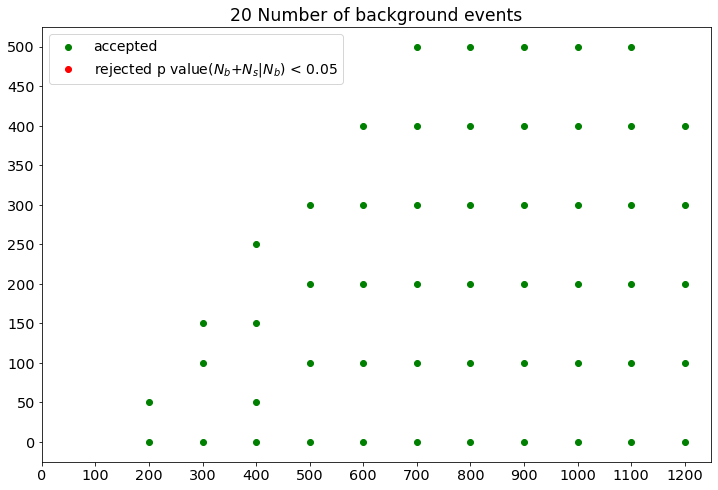

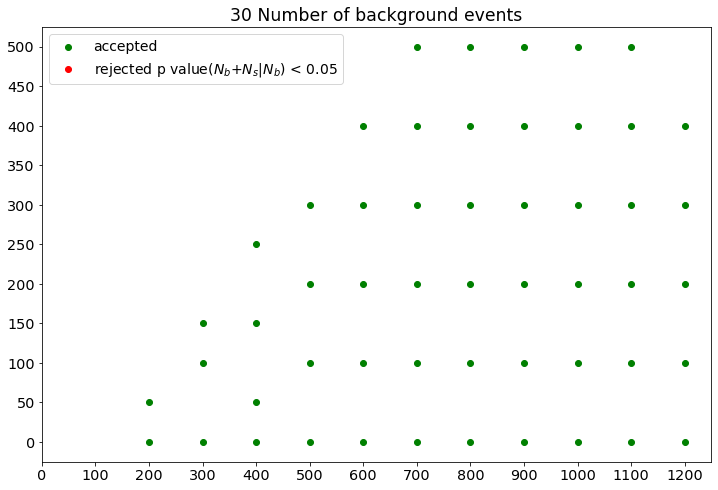

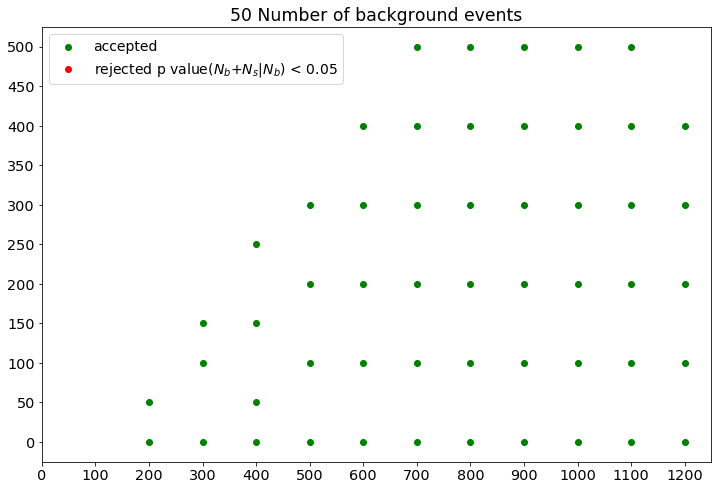

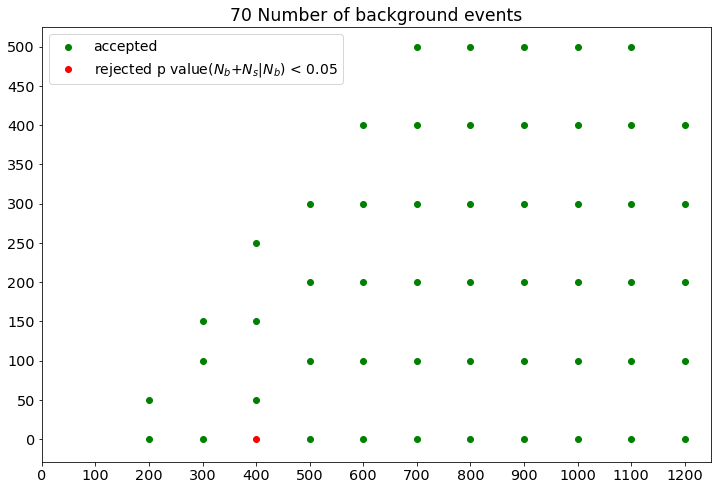

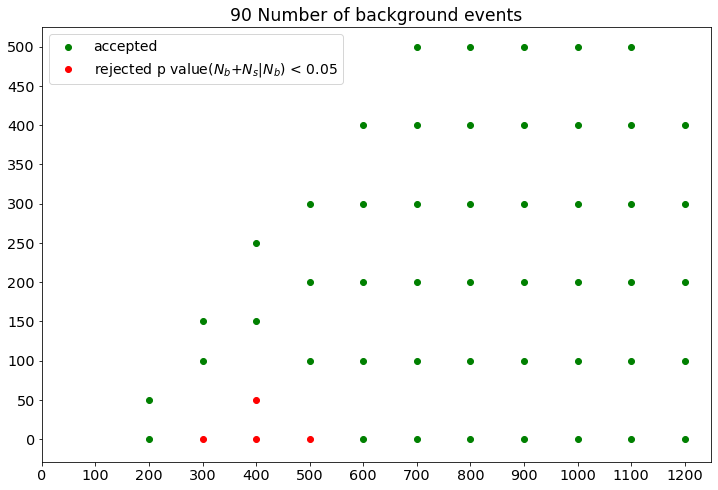

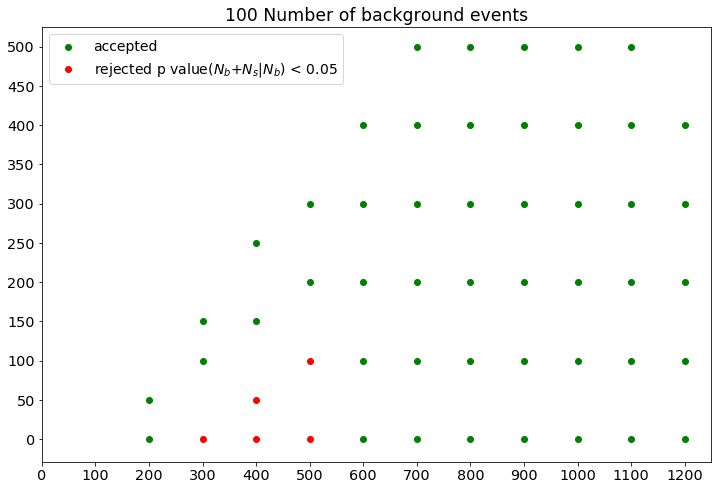

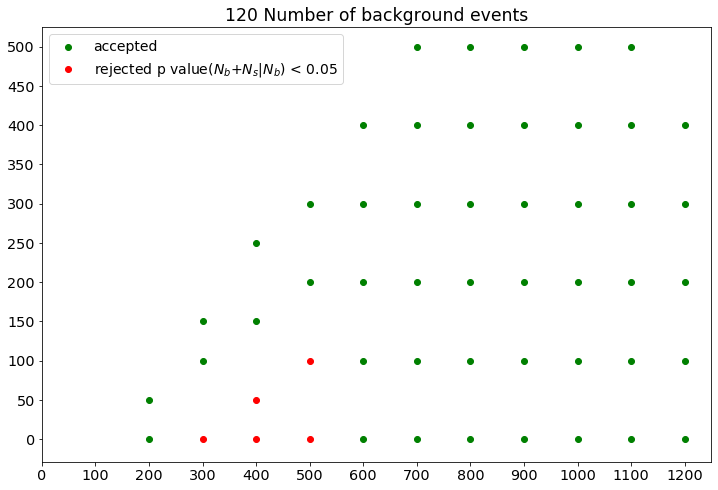

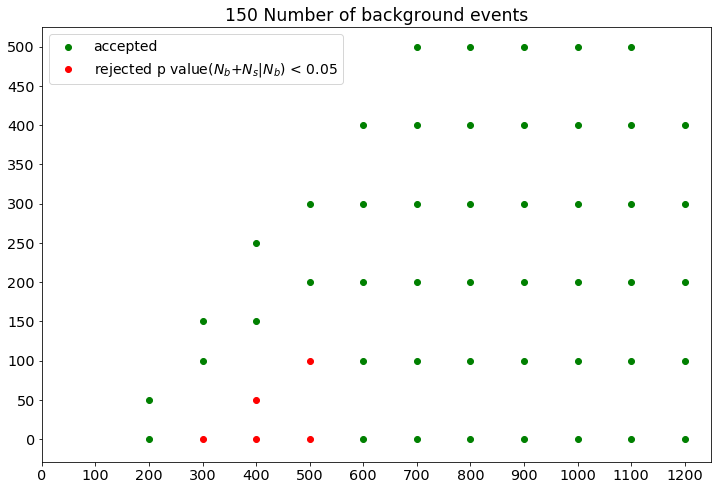

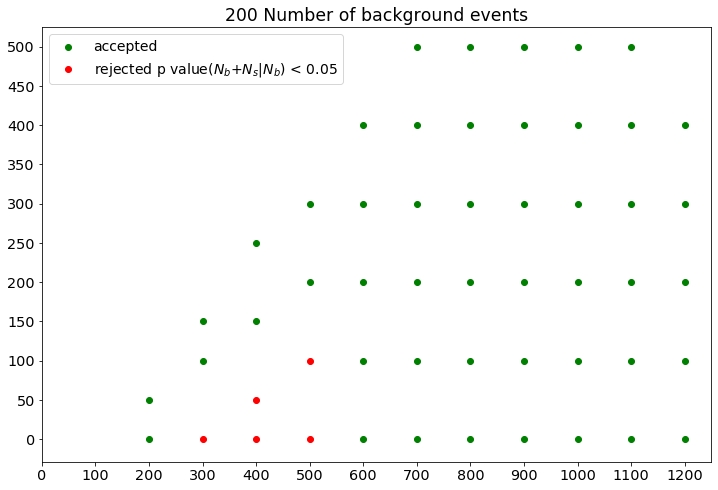

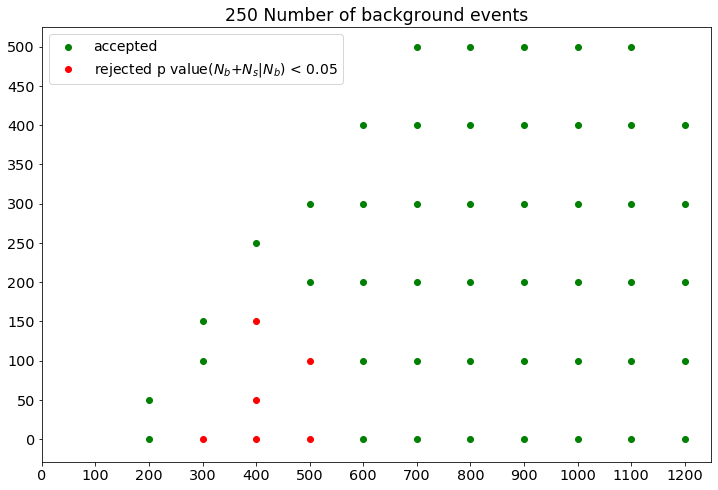

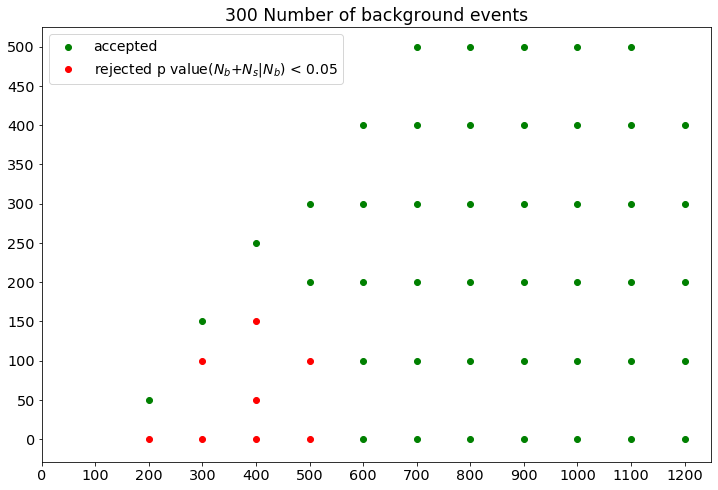

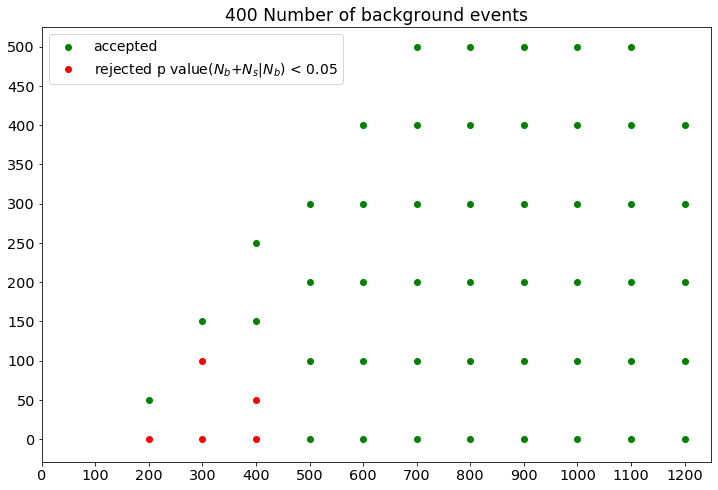

In [108]:
# f, ax_arr = plt.subplots(len(events_number),1 , figsize=(12,8*len(N)))
accepted_name = []
rejected_name = []
for i, n in enumerate(events_number):     
        f, ax_arr = plt.subplots(1,1 , figsize=(12,8))
        x_acc=[]
        y_acc=[]
        x_rej=[]
        y_rej=[]
        for j, sig_name in enumerate(signal_name):
            pv = p_v_dict[sig_name][str(n)][-1][0]
            
            if (pv > 0.05):

                x_acc.append(int(sig_name.split('_')[0]))
                y_acc.append(int(sig_name.split('_')[1]))                        
                                
            else:

                x_rej.append(int(sig_name.split('_')[0]))
                y_rej.append(int(sig_name.split('_')[1]))
                
                    

        ax_arr.scatter(x_acc, y_acc, color = 'green',
                                          label = 'accepted')      
        ax_arr.scatter(x_rej, y_rej, color = 'red', label = 'rejected p value($N_{b}$+$N_{s}$|$N_{b}$) < 0.05')    
        ax_arr.set_title('{} Number of background events'.format(n)
                            , size='xx-large')
        ax_arr.set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
        ax_arr.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
        ax_arr.legend(fontsize = 14, loc='upper left')
        ax_arr.tick_params(labelsize='x-large')  

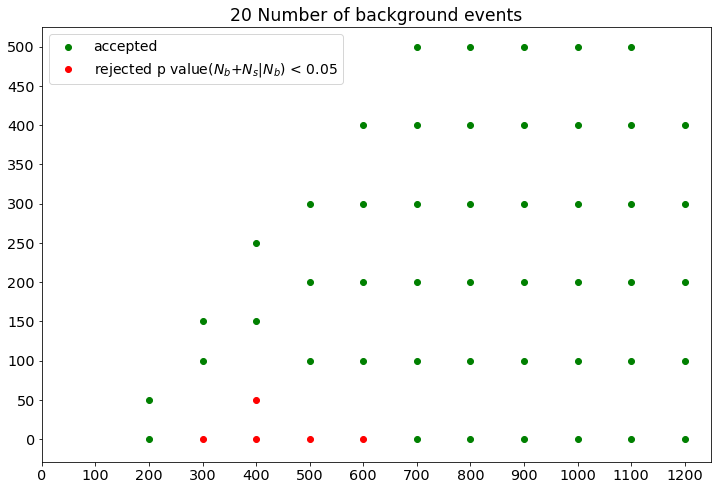

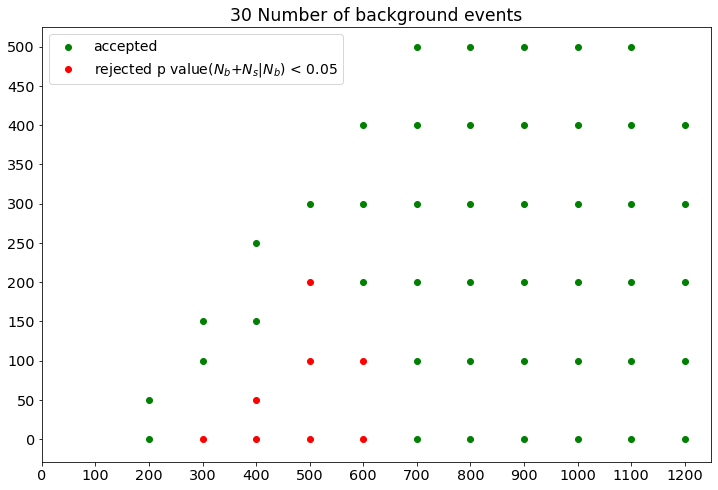

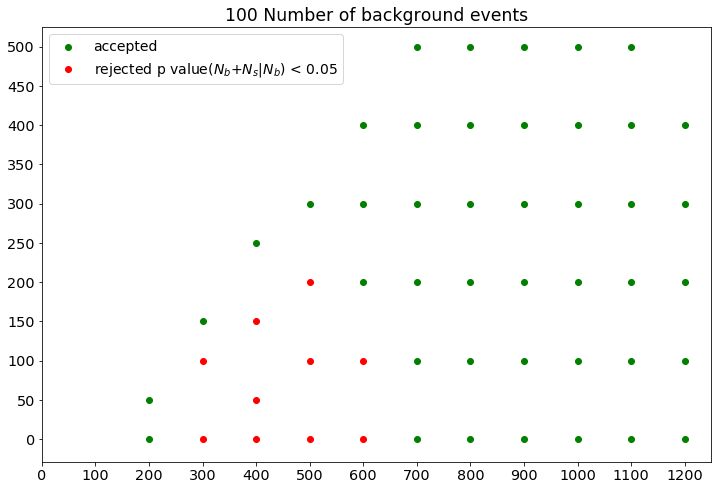

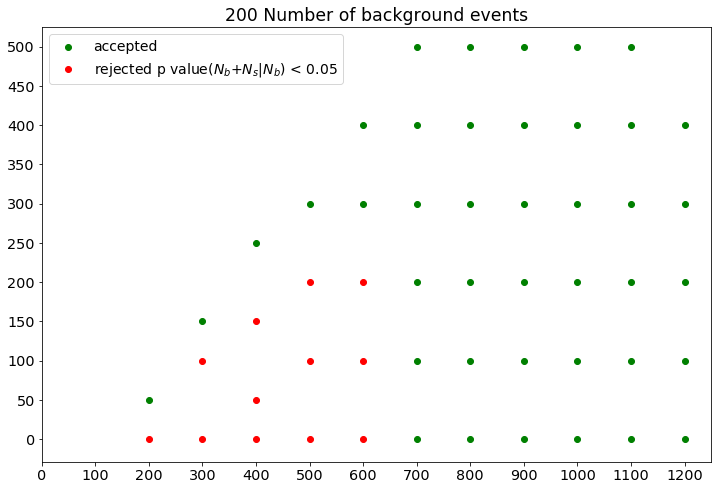

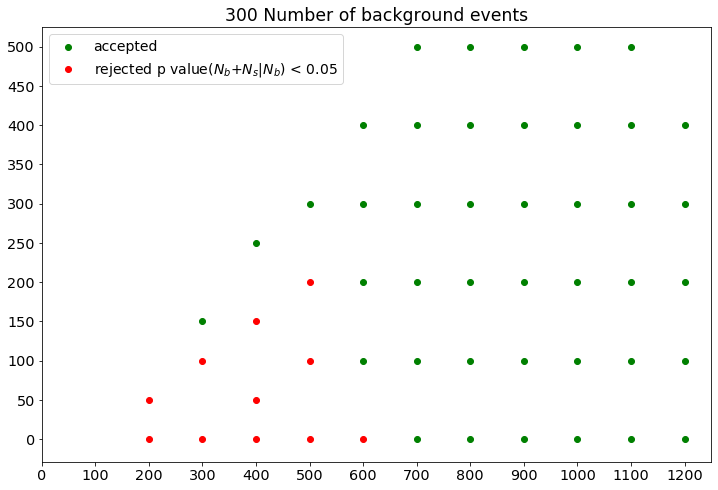

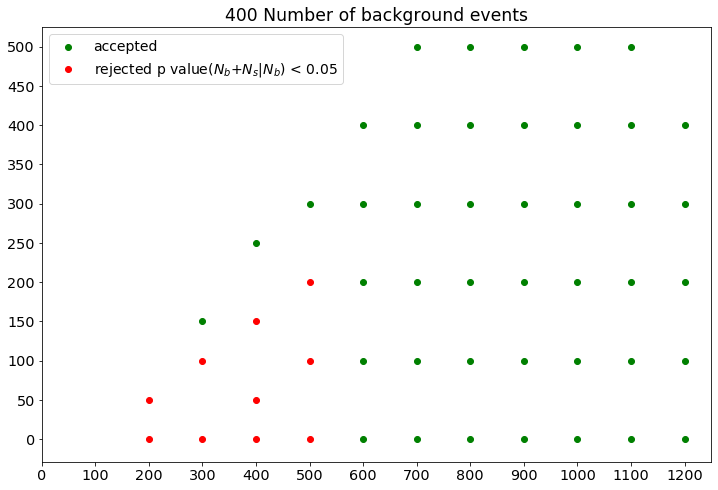

In [136]:
# f, ax_arr = plt.subplots(len(events_number),1 , figsize=(12,8*len(N)))
accepted_name = []
rejected_name = []
for i, n in enumerate(events_number):     
        f, ax_arr = plt.subplots(1,1 , figsize=(12,8))
        x_acc=[]
        y_acc=[]
        x_rej=[]
        y_rej=[]
        for j, sig_name in enumerate(signal_name):
            pv = p_v_dict[sig_name][str(n)][-1][0]
            
            if (pv > 0.05):

                x_acc.append(int(sig_name.split('_')[0]))
                y_acc.append(int(sig_name.split('_')[1]))                        
                                
            else:

                x_rej.append(int(sig_name.split('_')[0]))
                y_rej.append(int(sig_name.split('_')[1]))
                
                    

        ax_arr.scatter(x_acc, y_acc, color = 'green',
                                          label = 'accepted')      
        ax_arr.scatter(x_rej, y_rej, color = 'red', label = 'rejected p value($N_{b}$+$N_{s}$|$N_{b}$) < 0.05')    
        ax_arr.set_title('{} Number of background events'.format(n)
                            , size='xx-large')
        ax_arr.set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
        ax_arr.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
        ax_arr.legend(fontsize = 14, loc='upper left')
        ax_arr.tick_params(labelsize='x-large')  


In [ ]:
dic = []
x_list_n = []
y_list_n = []
pv_list = []
pv_list_d = []
pv_list_u = []
lista = []
for k, value in (p_v_dict_both.items()):
    
    tt = value[0][0]
    ttd = p_v_dict_l[k][0][0]
    ttu = p_v_dict_u[k][0][0]
    
    pv_list.append(1- stats.norm.cdf(tt))
    pv_list_d.append(1- stats.norm.cdf(ttd))
    pv_list_u.append(1- stats.norm.cdf(ttu))

    x_list_n.append(int(k.split('_')[0]))
    y_list_n.append(int(k.split('_')[1]))
    
    dic_temp = {}
    
    dic_temp = {'x':int(k.split('_')[0]),
               'y':int(k.split('_')[1]),
               'CLs':pv_list[-1], #Observed
               'CLsexp':pv_list[-1], #Expected
               "clsu1s":pv_list_u[-1],
                "clsu2s":pv_list_u[-1],
                
                "clsd1s":pv_list_d[-1],
                "clsd2s":pv_list_d[-1],
                
                "upperLimit":pv_list_u[-1],
                "expectedUpperLimit":pv_list_u[-1]
               }
    
    dic.append(dic_temp)

# dic['sample'] = lista
    
# dic['x']=x_list_n
# dic['y']=y_list_n
# dic['zValues']=pv_list
with open('nominal_550_300_boot_3_feats.json', 'w') as outfile:
    json.dump(dic, outfile)